# Grade Bonus Task

In your grade bonus task, you will investigate what **Bonus Certificates** are and how to price them. You may ignore credit risk considerations. Moreover, assumem any fraction of securities is tradable at any time and that riskless return of the Bank account is given by r = 2% p.a.


### **Task 1:** Plot the evolution of the stock and the log-returns and investigate their mean, std, minimum, maximum and their quartiles

In this task, we:

1. **Visualize** the historical evolution of the stock price.
2. **Compute summary statistics** of the stock price:
  - Mean
  - Standard Deviation
  - Minimum / Maximum (with corresponding dates)
  - Quantiles (25%, 50%, 75%)

First we check what kind of data we have and the general structure.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv("Telekom.csv", header = 0)

In [3]:
data.head()

,Date,Close
0,2014-06-17,12.585
1,2014-06-18,12.660
2,2014-06-19,12.800
3,2014-06-20,12.735
4,2014-06-23,12.675


In [4]:
data.columns

Index(['Date', 'Close'], dtype='object')

In [5]:
data.dtypes

Date      object
Close    float64
dtype: object

In [6]:
# Date to DateTime
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Close
0,2014-06-17,12.585
1,2014-06-18,12.660
2,2014-06-19,12.800
3,2014-06-20,12.735
4,2014-06-23,12.675


In [7]:
data.set_index('Date', inplace=True)
data.head()

,Close
Date,
2014-06-17,12.585
2014-06-18,12.660
2014-06-19,12.800
2014-06-20,12.735
2014-06-23,12.675


### Stock Values

Text(0, 0.5, 'Value $')

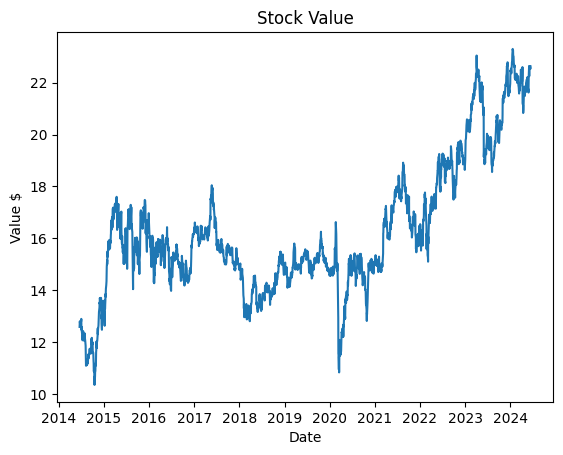

In [8]:
plt.title("Stock Value")
plt.plot(data["Close"])
plt.xlabel("Date")
plt.ylabel("Value $")

In [9]:
stats = [
    
    ('Mean', data['Close'].mean()),
    ('Std Dev', data['Close'].std()),
    (f"Min (on {data['Close'].idxmin().date()})", data['Close'].min()),
    (f"Max (on {data['Close'].idxmax().date()})", data['Close'].max()),
    ('25% Quantile (Q1)', data['Close'].quantile(0.25)),
    ('Median (Q2)', data['Close'].quantile(0.50)),
    ('75% Quantile (Q3)', data['Close'].quantile(0.75)),
]

# Turn the list into a DataFrame and keep the name 'stats'
stats = pd.DataFrame(stats, columns=['Statistics of Returns', 'Value'])
stats['Value'] = round(stats['Value'],2)
stats



,Statistics of Returns,Value
0,Mean,16.28
1,Std Dev,2.59
2,Min (on 2014-10-16),10.35
3,Max (on 2024-01-22),23.30
4,25% Quantile (Q1),14.77
5,Median (Q2),15.64
6,75% Quantile (Q3),17.48


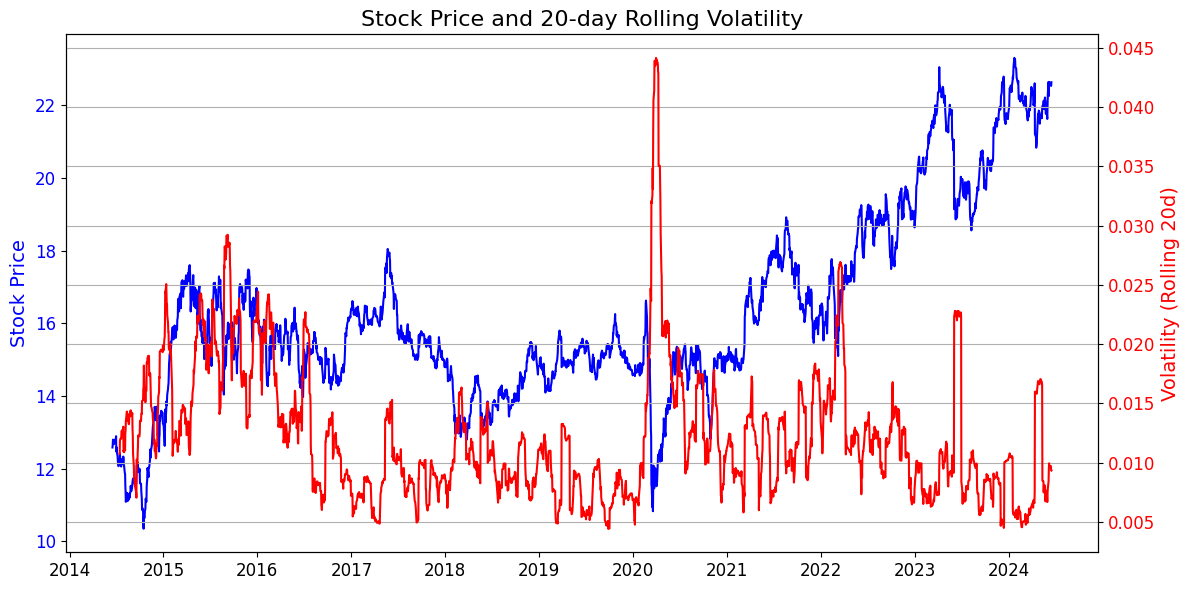

In [12]:
# Ajustar el tamaño de fuente de los ejes y etiquetas según lo indicado

fig, ax1 = plt.subplots(figsize=(12, 6))


ax1.plot(data.index, data['Close'], color='blue', label='Close Price')
ax1.set_ylabel('Stock Price', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)


ax2 = ax1.twinx()
ax2.plot(data.index, data['volatility'], color='red', label='20-day Volatility')
ax2.set_ylabel('Volatility (Rolling 20d)', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)

plt.title('Stock Price and 20-day Rolling Volatility', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


### Log Returns

$$
r_t = ln\left(\frac{P_{t+i}}{P_t}\right) = ln(P_{t+1})-ln(P_t)
$$

This transformation is useful because log returns are:
- **Time additive** over multiple periods,
- **Approximately normally distributed**, especially over short intervals.



In [30]:
logPrices = np.log(np.array(data["Close"]))
data["LogReturn"] = np.log(data['Close']).diff()
data.tail()

,Close,LogReturn
Date,,
2024-06-10,22.610001,0.000885
2024-06-11,22.610001,0.000000
2024-06-12,22.540001,-0.003101
2024-06-13,22.530001,-0.000444
2024-06-14,22.629999,0.004429


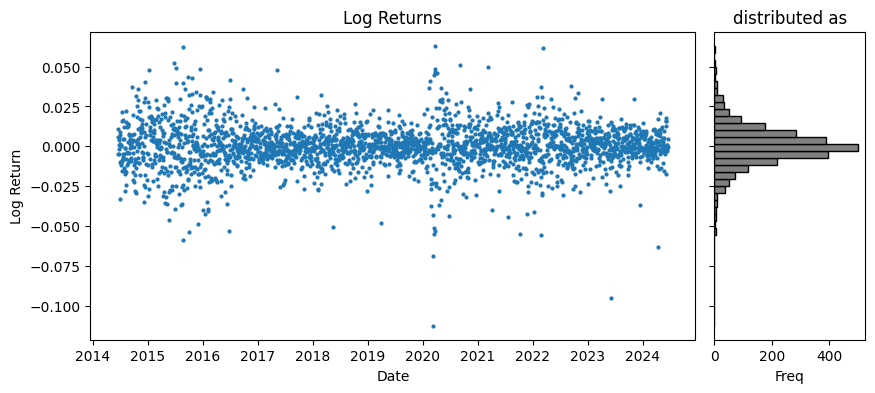

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.05})

ax1.plot(data.index, data['LogReturn'], marker='.', ls='',markersize='4')
ax1.set_title('Log Returns')
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Return')

ax2.set_title('distributed as')
ax2.hist(data['LogReturn'].dropna(), bins=40, orientation='horizontal', color='gray', edgecolor='black',density=False)
ax2.set_xlabel('Freq')
ax2.tick_params(labelleft=False)  # Hide y-axis labels on histogram


plt.show()

In [31]:
logReturns = data['LogReturn'].dropna()
logstats = {
    'Mean': logReturns.mean(),
    'Std': logReturns.std(),
    'Minimum': logReturns.min(),
    'Maximum': logReturns.max(),
    '25% Quantile (Q1)': logReturns.quantile(0.25),
    'Median (Q2)': logReturns.quantile(0.50),
    '75% Quantile (Q3)': logReturns.quantile(0.75),
}

# Convert to DataFrame
pd.DataFrame.from_dict(logstats, orient='index', columns=['Value'])


,Value
Mean,0.000231
Std,0.013379
Minimum,-0.112673
Maximum,0.063141
25% Quantile (Q1),-0.005909
Median (Q2),0.000000
75% Quantile (Q3),0.007092


Let's now compute the **drawdowns** of the stock prices. Drawdowns measure the decline of a stock price from its peak to a subsequent low. This captures downside risk and helps assess the severity and duration of potential losses.

In [13]:
def drawdown(prices_series: pd.Series):
    """Takes a time series of asset prices.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    return_series = prices_series.pct_change()
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

data_drawdown = drawdown(data["Close"])
data_drawdown.head()


,Wealth,Previous Peak,Drawdown
Date,,,
2014-06-17,NaN,NaN,NaN
2014-06-18,1005.959460,1005.959460,0.000000
2014-06-19,1017.083842,1017.083842,0.000000
2014-06-20,1011.918921,1017.083842,-0.005078
2014-06-23,1007.151383,1017.083842,-0.009766


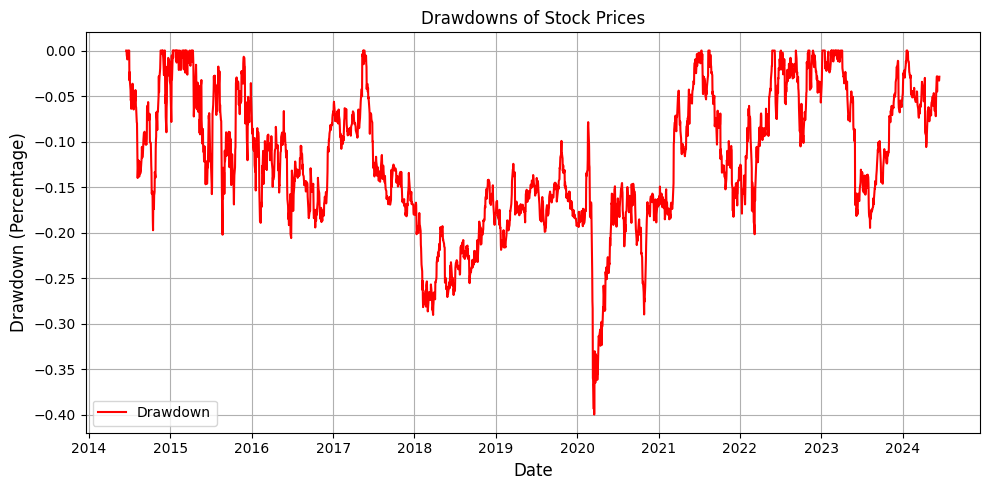

Maximum Drawdown: -0.39972292973399604


In [14]:
# Plot with proper labels and style
plt.figure(figsize=(10, 5))
plt.plot(data_drawdown.index, data_drawdown["Drawdown"], label="Drawdown", color="red")
plt.title("Drawdowns of Stock Prices")
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Drawdown (Percentage)", fontsize = 12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Maximum Drawdown: {data_drawdown["Drawdown"].min()}")

### **Task 2:** Fit a Black-Scholes model to the time series *Telekom.csv*

In this task, we estimate the parameters of the **Black-Scholes model** using historical price data from `Telecom.csv`.

The **Black-Scholes** model assumes the asset price follows the stochastic differential equation (SDE). This model is given by:
$$
dB_t = rB_tdt, B_0 =1
$$
$$
dP_t = P_t(bdt+\sigma dW_t), P_0 = p_0>0
$$
$$
P_t = P_0 \exp\left(b-\frac{1}{2}\sigma^2\right)t+\sigma W_t
$$
$$
b = \frac{E[\frac{P_{t+1}}{P_t}]}{\Delta t}+\frac{1}{2}\sigma^2
$$

**Estimation via Log Returns**

Using a time series of prices $P_t$, we approximate the differential of the log price by the **discrete log return**:

$$
d(\log P_t) \approx r_t = \log(P_{t+1}) - \log(P_t)
$$

From this, we can estimate the model parameters:

- **Volatility (σ)**:
  $$
  \sigma \approx \text{std}(r_t)
  $$

- **Drift (b)**:
  $$
  b \approx \text{mean}(r_t) + \frac{1}{2} \sigma^2
  $$

In [15]:
P0 = np.array(data["Close"])[0]
r = 0.02  # by assumption
sigma = logstats["Std"] * np.sqrt(252)
b = logstats["Mean"] * 252 + 0.5 * sigma * sigma

print('The parameters of the Black-Scholes Model are:')
print(f'Initial Price P0 ($):       {P0:.2f}')
print(f'Interest Rate (annual):    {r:.2%}')
print(f'Volatility σ (annual):      {sigma:.4f}')
print(f'Drift b (annual):               {b:.4f}')


The parameters of the Black-Scholes Model are:
Initial Price P0 ($):       12.59
Interest Rate (annual):    2.00%
Volatility σ (annual):      0.2124
Drift b (annual):               0.0808


### 

### **Task 3:** What are Bonus Certificates? Draw their payoff profile. Why would an investor buy any of those certificates? Which risks should be considered?

Bonus Certificates are structured financial products that offer investors participation in the performance of an underlying asset (e.g., a stock or index), while also providing partial downside protection and the possibility of a bonus payment at maturity.

They are popular retail derivatives in Europe and are issued by banks. These products usually combine:

- A **long position** in the underlying (or a portion of it)
- A **short put option** (sold by the investor)
- A **bonus feature** that rewards the investor if a barrier is not breached

---

**Payoff at maturity**

Let:

- $ P_T $: price of the underlying at maturity
- $ H $: barrier level
- $ B $: bonus level (guaranteed payoff if barrier is not touched)

Then the payoff $ \text{Bonus}(T) $ is typically:

$$
\text{Bonus}(T) =
\begin{cases}
\max(B,P_T) & \text{if } P_t > H \text{ for all } t \in [0, T] \\
P_T & \text{if } P_t \leq H \text{ at any time}
\end{cases}
$$

The payoff of a capped bonus certificate is given by:
$$
\text{Bonus}(T,C) = \min(\text{Bonus}(T),C)

$$

This means:

- If the **barrier is never breached**, the investor gets at least the bonus level $ B $.
- If the **barrier is breached**, the investor simply receives the final value $ P_T $, just like holding the underlying asset.
- In both cases, the maximum payoff you can get is $C$, when the **bonus certificate is capped**
-----

**Why Would an Investor Buy One?**

Investors are drawn to Bonus Certificates for several reasons:

- *Partial downside protection*: as long as the barrier isn't breached, the bonus guarantees a minimum return.
- *Enhanced returns in sideways markets*: if the underlying stagnates but doesn't fall below the barrier, the investor still gets the bonus.

---

**Risks to Consider**

While attractive, Bonus Certificates carry important risks:

1. *Barrier breach risk*: if the barrier is touched, protection is lost and the investor participates fully in losses.
2. *Credit risk*: the product is issued by a bank — if the issuer defaults, the protection and return may be worthless.
3. *Liquidity risk*: they may not be easily tradable in the secondary market.


<!-- A **Bonus Certificate** is a structured financial product that allows investors to benefit from moderate upward movements of the underlying asset while offering partial downside protection. It typically includes a fixed interest component and guarantees a predefined bonus payout at maturity, provided that the underlying asset never breaches a specified lower barrier during the product’s life.

If the asset’s price remains above this safety threshold, the investor receives either the bonus amount or the final asset value, whichever is higher.

However, if the barrier is breached at any time, the protection mechanism is lost. From that moment on, the certificate behaves like a direct investment in the underlying asset, and the investor bears full downside risk without the right to the bonus payout. -->

In [16]:
!pip install ipywidgets


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import ipywidgets as widgets
from IPython.display import display

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def bonus_certificate_plot(BonusLevel=110, Barrier=70):
    P_T = np.linspace(50, 150, 500)
    P_0 = 100

    # Payoff  Bonus Certificate
    payoff = np.where(
        P_T >= Barrier,                    # Not touched barrier
        np.maximum(P_T, BonusLevel),      # Cobras el máximo entre precio final y bonus garantizado
        P_T                                # broken barrier once → stock owners
    )

    profit = payoff - P_0
    stock_profit = P_T - P_0

    # Gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(P_T, profit, label='Classic Bonus Certificate Profit/Loss', color='blue')
    plt.plot(P_T, stock_profit, '--', label='Stock Profit/Loss', color='gray')

    # reference lines
    plt.axhline(0, color='black', linestyle='-')
    plt.axvline(Barrier, color='red', linestyle=':', label='Barrier (Safety Threshold)')
    plt.axhline(BonusLevel - P_0, color='green', linestyle='--', label='Minimum Guaranteed Profit')
    plt.axvline(BonusLevel, color='yellow', linestyle='--', label='Bonus Level (Payoff €)')

    plt.xlabel('Final Stock Price $P_T$')
    plt.ylabel('Profit / Loss')
    plt.title('Bonus Certificate vs Direct Stock Investment')
    plt.legend()
    plt.grid(True)
    plt.show()

# Widgets 
interactive_plot = widgets.interactive(
    bonus_certificate_plot,
    BonusLevel=(100, 130, 1),
    Barrier=(50, 100, 1)
)

display(interactive_plot)



interactive(children=(IntSlider(value=110, description='BonusLevel', max=130, min=100), IntSlider(value=70, de…

### **Task 4:** Find a portfolio of products you know from the lecture and the exercices that replicate the certificate.

To replicate the classic bonus certificate, we consider a **long position in the underlying** and a **down-and-out put option** with strike equal to the bonus level $K$ and barrier $B$.

- The **underlying** provides a payoff of $P_T$ at maturity.
- The **down-and-out put** pays $K - P_T$ if $P_T < K$ and the barrier $B$ has **not** been breached during the product's lifetime. Otherwise, it expires worthless.

Thus, the **total payoff** becom- If the barrier was not breached:  
  $$
  \text{Payoff} = (P_T + \max(K - P_T, 0)) - P_0 = \max(P_T, K) - P_0
  $$  
  which results in a **guaranteed minimum** of $K - P_0$.

- If the barrier was breached:  
  $$
  \text{Payoff} = P_T - P_0
  $$  
  and the product behaves like a direct investment in the stock.
in the stock.

This replication captures the core behavior of a classic bonus certificate: **capital protection up to the barrier** and linear participation otherwise.
pation otherwise.
 n otherwise.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Function to simulate GBM
def simulate_gbm(S0, T, N, mu, sigma):
    dt = T / N
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size=N)
    W = np.insert(np.cumsum(np.sqrt(dt) * W), 0, 0)

    drift = mu  
    S = S0 * np.exp((drift - 0.5 * sigma**2) * t + sigma * W)
    return t, S

# Global variables
global_barrier_breached = None
global_final_price = None
global_P0 = 100

# Plot function with barrier
def plot_gbm_with_barrier(mu, sigma, T, N,  barrier, S0=global_P0):
    global global_barrier_breached, global_final_price

    t, S = simulate_gbm(S0, T, N, mu, sigma)
    breached = np.any(S < barrier)
    final_price = S[-1]

    # Store results
    global_barrier_breached = breached
    global_final_price = final_price

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(t, S, label='GBM Path')
    plt.axhline(y=barrier, color='red', linestyle='--', label=f'Barrier Level: {barrier}')
    plt.title("GBM Simulation with Barrier Check")
    plt.xlabel("Time (Years)")
    plt.ylabel("Stock Price")
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.grid(True)
    plt.show()

    if breached:
        print(f" Barrier was breached during the simulation.")
    else:
        print(f" Barrier was NOT breached.")
    print(f" Final Price: {final_price:.2f}")

# Interactive widget
interactive_gbm_barrier = widgets.interactive(
    plot_gbm_with_barrier,
    S0=widgets.FloatSlider(value=100, min=10, max=160, step=5, description='Initial Price'),
    mu=widgets.FloatSlider(value=0.05, min=-0.1, max=0.2, step=0.005, description='Drift μ'),
    sigma=widgets.FloatSlider(value=0.05, min=0.01, max=1.0, step=0.01, description='Volatility σ'),
    T=widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Time (yrs)'),
    N=widgets.IntSlider(value=500, min=50, max=1000, step=10, description='Steps'),
    r=widgets.FloatSlider(value=0.02, min=0.0, max=0.1, step=0.005, description='Risk-Free Rate'),
    barrier=widgets.FloatSlider(value=90, min=0, max=200, step=1, description='Barrier Level')
)

display(interactive_gbm_barrier)


interactive(children=(FloatSlider(value=0.05, description='Drift μ', max=0.2, min=-0.1, step=0.005), FloatSlid…

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
def plot_classic_bonus_replication(BonusLevel=110, BarrierLevel=90, P0=global_P0, BarrierBreached=global_barrier_breached, premium=5):
    """
    Interactive plot for replicating a Classic Bonus Certificate.

    Inputs:
    - BonusLevel: Strike price of the down-and-out put option.
    - BarrierLevel: Barrier below which the bonus protection is lost.
    - P0: Initial price of the underlying.
    - BarrierBreached: 'Yes' if the barrier was touched during the product's lifetime, 'No' otherwise.
    - premium: cost to buy the certificate
    """
    P_T = np.linspace(50, 190, 500)
    K = BonusLevel

    # Handle both global bool or widget string
    if isinstance(BarrierBreached, str):
        breached = BarrierBreached == 'Yes'
    else:
        breached = BarrierBreached

    stock_payoff = P_T
    put_payoff = np.zeros_like(P_T)

    if not breached:
        valid_region = P_T >= BarrierLevel
        put_payoff[valid_region] = np.maximum(K - P_T[valid_region], 0)
    else:
        valid_region = np.full_like(P_T, True, dtype=bool)

    total_payoff = np.where(valid_region, stock_payoff + put_payoff, np.nan)
    profit_total = total_payoff - P0 - premium
    stock_profit = P_T - P0

    plt.figure(figsize=(10, 5))
    plt.plot(P_T, profit_total, label='Bonus Certificate Replication', color='blue', linewidth=2)
    plt.plot(P_T, stock_profit, '--', label='Stock Only', color='gray')
    plt.axhline(0, color='black')
    plt.axvline(BonusLevel, color='green', linestyle='--', label='Bonus Level')
    plt.axvline(BarrierLevel, color='red', linestyle='--', label='Barrier Level')
    title = "No Barrier Breach (only $P_T \\geq$ Barrier)" if not breached else "Barrier Breached"
    plt.title(f'Classic Bonus Certificate Replication ({title})')
    plt.xlabel('Final Stock Price $P_T$')
    plt.ylabel('Profit / Loss')
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.show()

# Interactive widget setup
interactive_plot_bonus_corrected = widgets.interactive(
    plot_classic_bonus_replication,
    BonusLevel=widgets.IntSlider(value=140, min=100, max=140, step=1),
    premium=widgets.IntSlider(value=5, min=0, max=20, step=1),
    BarrierLevel=widgets.IntSlider(value=70, min=70, max=100, step=1),
    P0=widgets.IntSlider(value=100, min=80, max=120, step=1),
    BarrierBreached=widgets.Dropdown(
        options=[('No', 'No'), ('Yes', 'Yes')],
        value='No',
        description='Barrier Breached:'
    )
)

display(interactive_plot_bonus_corrected)


interactive(children=(IntSlider(value=140, description='BonusLevel', max=140, min=100), IntSlider(value=70, de…

To replicate the **capped bonus certificate**, we combine three components:  
a **long position in the underlying**, a **down-and-out put option** with strike equal to the bonus level $K$ and barrier $B$, and a **short call option** with strike equal to the cap level $C$.

- The **underlying** provides a payoff of $P_T$ at maturity.
- The **down-and-out put** pays $K - P_T$ if $P_T < K$ and the barrier $B$ has **not** been breached during the product's lifetime. It expires worthless otherwise.
- The **short call** subtracts $\max(P_T - C, 0)$ if $P_T > C$, effectively capping the upside.

The total payoff depends on whether the barrier has been breached:

- **If the barrier was not breached**:  
  $$
  \text{Payoff} = \left(P_T + \max(K - P_T, 0) - \max(P_T - C, 0)\right) - P_0
  $$  
  This results in a payoff that:
  - Guarantees at least $K - P_0$ if $P_T \geq B$
  - Caps the maximum gain at $C - P_0$

- **If the barrier was breached**:  
  $$
  \text{Payoff} = (P_T - \max(P_T - C, 0)) - P_0 = \min(P_T, C) - P_0
  $$  
  The product loses its capital protection and behaves like a **capped equity participation**.

This replication strategy reproduces the key features of a capped bonus certificate:  
**downside protection (unless the barrier is breached)** and **upside capped participation**.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_capped_bonus_replication(BonusLevel=110, BarrierLevel=90, CapLevel=130, P0=global_P0, BarrierBreached=global_barrier_breached):
    """
    Interactive plot for replicating a Capped Bonus Certificate.

    Inputs:
    - BonusLevel: Strike price of the down-and-out put option.
    - BarrierLevel: Barrier below which the bonus protection is lost.
    - CapLevel: Strike price of the short call that limits upside participation.
    - P0: Initial price of the underlying.
    - BarrierBreached: 'Yes' if the barrier was touched during the product's lifetime, 'No' otherwise.

    Explanation:
    - The product is replicated by combining:
      - Long in the underlying
      - Down-and-out put with strike = BonusLevel and barrier = BarrierLevel
      - Short call with strike = CapLevel
    - If the barrier is not breached, payoff is only defined for P_T ≥ BarrierLevel.
    """
    P_T = np.linspace(50, 150, 500)
    K = BonusLevel
    C = CapLevel

    # Convert widget string to boolean if needed
    if isinstance(BarrierBreached, str):
        breached = BarrierBreached == 'Yes'
    else:
        breached = BarrierBreached

    stock_payoff = P_T
    put_payoff = np.zeros_like(P_T)
    short_call = -np.maximum(P_T - C, 0)

    if not breached:
        valid_region = P_T >= BarrierLevel
        put_payoff[valid_region] = np.maximum(K - P_T[valid_region], 0)
    else:
        valid_region = np.full_like(P_T, True, dtype=bool)

    total_payoff = np.where(valid_region, stock_payoff + put_payoff + short_call, np.nan)
    profit_total = total_payoff - P0
    stock_profit = P_T - P0

    plt.figure(figsize=(10, 5))
    plt.plot(P_T, profit_total, label='Capped Bonus Certificate Replication', color='blue', linewidth=2)
    plt.plot(P_T, stock_profit, '--', label='Stock Only', color='gray')
    plt.axhline(0, color='black')
    plt.axvline(BonusLevel, color='green', linestyle='--', label='Bonus Level')
    plt.axvline(BarrierLevel, color='red', linestyle='--', label='Barrier Level')
    plt.axvline(CapLevel, color='orange', linestyle='--', label='Cap Level')
    title = "No Barrier Breach (only $P_T \\geq$ Barrier)" if not breached else "Barrier Breached"
    plt.title(f'Capped Bonus Certificate Replication ({title})')
    plt.xlabel('Final Stock Price $P_T$')
    plt.ylabel('Profit / Loss')
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.show()


interactive_plot_capped_bonus = widgets.interactive(
    plot_capped_bonus_replication,
    BonusLevel=widgets.IntSlider(value=110, min=100, max=130, step=1),
    BarrierLevel=widgets.IntSlider(value=90, min=70, max=100, step=1),
    CapLevel=widgets.IntSlider(value=130, min=110, max=150, step=1),
    P0=widgets.IntSlider(value=100, min=80, max=120, step=1),
    BarrierBreached=widgets.Dropdown(options=['No', 'Yes'], value='No', description='Barrier Breached:')
)

display(interactive_plot_capped_bonus)


interactive(children=(IntSlider(value=110, description='BonusLevel', max=130, min=100), IntSlider(value=90, de…

### **Task 5:** Determine a fair price for each of the certificates and compute it explicitly for the market parameters from Task 2) with $P_0$ equal to the price quoted on 14.06.2024, barreir level 16, bonus level 24 and maturity 1 year.

We compute the fair price of the bonus certificate for market parameters:  
$$
H = 16, \quad B = 24, \quad T = 1 \text{ year}
$$


The fair price corresponds to the **risk-neutral expected discounted payoff**:

$$
\begin{aligned}
\text{Bonus}(0) &= \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} P_T \right] 
+ \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} (B - P_T)^+ \cdot \mathbf{1}_{\{P_t > H, \, \forall t \in [0,T]\}} \right] \\
&= P_0 
+ \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} (P_T - B) \cdot \mathbf{1}_{\{P_t > H, \, \forall t \in [0,T]\}} \right] \\
&\quad 
- \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} (P_T - B)^+ \cdot \mathbf{1}_{\{P_t > H, \, \forall t \in [0,T]\}} \right] \\
&= P_0 + \text{DOC} - (P_0Q^{(1)} −e^{−r T}BQ^{(2)})
\end{aligned}
$$

where $\text{DOC}$ represent a down-and-out call option with strike $B$ and barrier $H$, and $Q^{(1)}$ and $Q^{(2)}$ are given by 

$$
\begin{aligned}
Q^{(1)} &= \mathcal{N}\left(\frac{\log \frac{P_0}{H} + \left(r + \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right) - \exp\left(-\frac{2\left(r + \frac{\sigma^2}{2}\right) \log \frac{P_0}{H}}{\sigma^2}\right) \mathcal{N}\left(\frac{-\log \frac{P_0}{H} + \left(r + \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right) \\
Q^{(2)} &= \mathcal{N}\left(\frac{\log \frac{P_0}{H} + \left(r - \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right) - \exp\left(-\frac{2\left(r - \frac{\sigma^2}{2}\right) \log \frac{P_0}{H}}{\sigma^2}\right) \mathcal{N}\left(\frac{-\log \frac{P_0}{H} + \left(r - \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right)
\end{aligned}
$$

Here, $\mathcal{N}(\cdot)$ is the standard normal cumulative distribution function.



A summary of the steps followed to derive the pricing formula is:

We begin with the risk-neutral expected discounted payoff of the bonus certificate:

$$
\text{Bonus}(0) = \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} P_T \right] 
+ \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} (B - P_T)^+ \cdot \mathbf{1}_{\{ \min_{t \in [0,T]} P_t < H \}} \right]
$$

Using that the discounted asset price is a martingale under $\tilde{\mathbb{Q}}$, the first term simplifies to $P_0$.

The second term is decomposed by introducing and subtracting the conditional call payoff when the barrier is not breached. This leads to:

$$
\text{Bonus}(0) = P_0 + \text{DOC} - \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} (P_T - B)^+ \cdot \mathbf{1}_{\{ \min_{t \in [0,T]} P_t > H \}} \right]
$$

The final expectation is evaluated using closed-form expressions from barrier option theory:


$$
\mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} (P_T - B)^+ \cdot \mathbf{1}_{\{ \min P_t > H \}} \right] = P_0 Q^{(1)} - e^{-rT} B Q^{(2)}
$$

Combining all terms gives the final pricing formula:

$$
\text{Bonus}(0) = P_0 + \text{DOC} - \left( P_0 Q^{(1)} - e^{-rT} B Q^{(2)} \right)
$$

The fair price of the **capped bonus certificate** can be computed by subtracting the price of a call option with strike $C$:

$$
\text{Bonus}(0,C) = \text{Bonus}(0) - \text{Call}(0,C)
$$

As expected, the capped bonus has a lower fair price due to its limited upside.

In [22]:
data.head()

,Close,LogReturn
Date,,
2014-06-17,12.585,NaN
2014-06-18,12.660,0.005942
2014-06-19,12.800,0.010998
2014-06-20,12.735,-0.005091
2014-06-23,12.675,-0.004723


In [23]:
print(data.index.min(), data.index.max())  # range
print("2024-06-14" in data.index)          # wheter or not


2014-06-17 00:00:00 2024-06-14 00:00:00
True


In [24]:
P0 = data["Close"][pd.to_datetime("2024-06-14")]
# H is the barrier level
H = 16
# B is the bonus level
B = 24
# C is the capped barrier for the capped bonus certificate
C = 50
# T is time to maturity (years)
T = 1
print(f'The parameters for the pricing are')
print(f'Maturity: {T} year(s)')
print(f'Initial Price: {P0:.3f}')
print(f'Interest rate: {r}')
print(f'Volatility: {sigma:.3f}')
print(f'Barrier H: {H}')
print(f'Bonus Level B: {B}')
print(f'Capped Payoff C: {C}')

The parameters for the pricing are
Maturity: 1 year(s)
Initial Price: 22.630
Interest rate: 0.02
Volatility: 0.212
Barrier H: 16
Bonus Level B: 24
Capped Payoff C: 50


In [25]:
from scipy.stats import norm
# incomplete Q1 and Q2 are not sufficient to calculate d&o put

def Call(P0,K,r,sigma,T):
    sigma2 = sigma * sigma          # sigma-squared makes the formula cleaner
    constant1 = (np.log(P0/K) + (r+0.5*sigma2)*T) / (sigma*np.sqrt(T))
    constant2 = constant1 - sigma * np.sqrt(T)
    Call = P0 * norm.cdf(constant1) - K * np.exp(-r*T) * norm.cdf(constant2)
    return Call

def DownAndOutCall(P0,K,H,r,sigma,T):
    if(P0<H): return 0
    sigma2 = sigma * sigma          # sigma-squared makes the formula cleaner
    constant1 = (np.log((H*H)/(P0*K)) + (r+0.5*sigma2)*T) / (sigma*np.sqrt(T))
    constant2 = constant1 - sigma * np.sqrt(T)
    lam = r - 0.5*sigma2
    KnockOutDiscount = P0 * (H/P0)**(2 + 2*lam/sigma2) * norm.cdf(constant1) - K * np.exp(-r*T) * (H/P0)**(2*lam/sigma2) * norm.cdf(constant2)
    return Call(P0,K,r,sigma,T) - KnockOutDiscount

def Q1(P0, H, r, sigma, T):
    log_term = np.log(P0 / H)
    drift = r + 0.5 * sigma**2
    denom = sigma * np.sqrt(T)

    term1 = norm.cdf((log_term + drift * T) / denom)
    
    exponent = - (2 * drift * log_term) / sigma**2
    term2 = np.exp(exponent) * norm.cdf((-log_term + drift * T) / denom)

    return term1 - term2

def Q2(P0, H, r, sigma, T):
    log_term = np.log(P0 / H)
    drift = r - 0.5 * sigma**2
    denom = sigma * np.sqrt(T)

    term1 = norm.cdf((log_term + drift * T) / denom)
    
    exponent = - (2 * drift * log_term) / sigma**2
    term2 = np.exp(exponent) * norm.cdf((-log_term + drift * T) / denom)

    return term1 - term2

def DownAndOutPut(P0,K,H,r,sigma,T):
    if(P0<H): return 0
    q1 = Q1(P0,H,r,sigma,T)
    q2 = Q2(P0,H,r,sigma,T)
    doc = DownAndOutCall(P0,K,H,r,sigma,T)
    dop = doc - (P0*q1 - np.exp(-r*T)*K*q2)
    return dop

def BonusCertificate(P0,B,H,r,sigma,T,Capped=None):
    """
    Computes the fair price of a Bonus Certificate using analytical formulas.

    The Bonus Certificate pays the final price of the underlying plus a down-and-out put payoff 
    if the barrier H is breached during [0, T]. If a cap C is provided, the payoff is limited 
    and the value of a call with strike C is subtracted.

    Parameters:
        P0 (float): Initial stock price
        B (float): Bonus level
        H (float): Lower barrier (knock-out level)
        r (float): Risk-free interest rate
        sigma (float): Volatility of the stock
        T (float): Time to maturity (in years)
        Capped (float or None): Cap level for the payoff. If None, the product is uncapped.

    Returns:
        dict: A dictionary containing input parameters and the computed fair price
              under the key "Bonus Price".
    """

    if(Capped==None):
        bonus =  P0 + DownAndOutPut(P0,B,H,r,sigma,T)
    elif(B<Capped):
        bonus =  P0 + DownAndOutPut(P0,B,H,r,sigma,T) - Call(P0,Capped,r,sigma,T)
    else:
        print('CAP level must be GREATER than BONUS level')
        return None
    
    results = {
    "Maturity (years)": T,
    "Initial Price": P0,
    "Interest Rate": r,
    "Volatility": sigma,
    "Barrier H": H,
    "Bonus Level B": B,
    "Capped Payoff C": Capped,
    "Bonus Price": bonus
    }
    return results

P0 = data["Close"][pd.to_datetime("2024-06-14")]
H = 16
B = 24
C = None
T = 1
results = BonusCertificate(P0,B,H,r,sigma,T,Capped=C)
pd.DataFrame([results]).T

,0
Maturity (years),1
Initial Price,22.629999
Interest Rate,0.02
Volatility,0.212393
Barrier H,16
Bonus Level B,24
Capped Payoff C,None
Bonus Price,24.250959


### Task 6: Monte Carlo Pricing

To approximate the risk-neutral expected payoff, we use the **law of large numbers** and simulate many paths of the underlying price process $P_t$ under the **risk-neutral measure** $\tilde{\mathbb{Q}}$.

According to the Black-Scholes model, the dynamics are:

$$
P_t = P_0 \, e^{\left(r - \frac{1}{2}\sigma^2\right) t + \sigma \tilde{W}_t}
$$

where $\tilde{W}_t$ is a Brownian motion under $\tilde{\mathbb{Q}}$.

We simulate multiple paths and compute the payoff at maturity as

$$
P_T + (B - P_T)^+ \cdot \mathbf{1}_{\{P_t > H, \ \forall t \in [0,T]\}}
$$

which includes the underlying payoff plus the bonus payoff if the barrier $H$ is never breached.


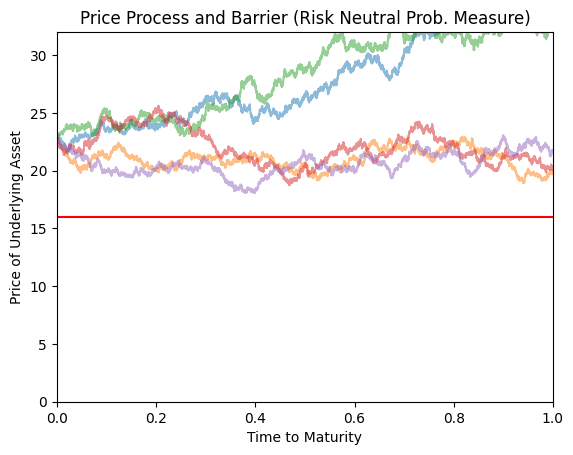

In [26]:
def BM(T,n):
    """
    Simulate a Brownian motion path.

    Parameters
    ----------
    T : float
        The time horizon.
    n : int
        The number of time steps.
    """
    dt = T / n
    t = np.linspace(0,T,n+1)
    W = np.zeros(n+1)
    # Cumulative sums of normal increments
    W[1:] = np.cumsum(np.sqrt(dt) * np.random.normal(size=n))
    return t, W

def PriceProcess(T,P0,sigma,r,n=10_000):
    """    
    Simulate a Geometric Brownian motion path.

    Parameters
    ----------
    T : float
        The time horizon.
    n : int
        The number of time steps.
    """
    dt = T / n
    t = np.linspace(0,T,n+1)
    X = np.zeros(n+1)
    X[1:] = np.cumsum(
        (r-0.5*sigma*sigma) * dt 
        + sigma * np.sqrt(dt) * np.random.standard_normal(size=n)
    )
    P = P0 * np.exp(X)
    return t,P

for _ in range(5):
    t,P = PriceProcess(T=T,P0=P0,sigma=sigma,r=r)
    plt.plot(t,P,alpha=0.5)

plt.plot([0,1],[H,H],color='red')
plt.xlim((0,1))
plt.ylim(0,2 * H)
plt.title('Price Process and Barrier (Risk Neutral Prob. Measure)')
plt.xlabel('Time to Maturity')
plt.ylabel('Price of Underlying Asset')
plt.show()


In [39]:
def BonusPayoff(Pt, H, B, Capped=None):
    """
    Computes the realized payoff of a Bonus Certificate given a simulated price path.

    Inputs:
    Pt : array-like
        Simulated price path over time.
    H : float
        Barrier level. If the path touches this level, the bonus is deactivated.
    B : float
        Bonus level. If the barrier is not breached, the investor is guaranteed
        at least min(B, final price).
    Capped : float or None
        Optional cap on the maximum payoff. If provided and B < Capped, the final
        payoff is capped at this level.

    Output:
    tuple
        (payoff_value, barrier_hit)
        payoff_value : float
            The final realized payoff.
        barrier_hit : bool
            True if the barrier was breached, False otherwise.
    """
    PT = Pt[-1]
    if np.min(Pt) > H:
        payoff = (PT + max(0, B - PT), False)
    else:
        payoff = (PT, True)

    if Capped is None:
        return payoff
    elif B < Capped:
        payoff = (min(payoff[0], Capped), payoff[1])
        return payoff
    else:
        print('CAP level must be GREATER than BONUS level')
        return None

for _ in range(10):
    _ ,Pt = PriceProcess(T,P0,sigma,r)
    payoff, hit = BonusPayoff(Pt,H,B,Capped=None)
    if (hit): print(f'Bonus Payoff: {payoff:.3f} Barrier Hit')
    else: print(f'Bonus Payoff: {payoff:.3f}')

Bonus Payoff: 24.000
Bonus Payoff: 24.000
Bonus Payoff: 24.000
Bonus Payoff: 17.609 Barrier Hit
Bonus Payoff: 24.000
Bonus Payoff: 26.595
Bonus Payoff: 24.000
Bonus Payoff: 24.000
Bonus Payoff: 16.079 Barrier Hit
Bonus Payoff: 24.078


In [45]:
from tqdm import tqdm
np.random.seed(33)

MC_steps = int(1_000_000)
def MCBonus(T,P0,r,sigma,B,H,Capped=None,steps=MC_steps):
    """
    Estimates the fair price of a Bonus Certificate using Monte Carlo simulation.

    The method simulates multiple price paths of a Geometric Brownian Motion under the
    risk-neutral measure, computes the payoff of the Bonus Certificate for each path, 
    and averages the discounted payoffs to approximate the expected value.

    Inputs
    T : float
        Time to maturity (in years).
    P0 : float
        Initial asset price.
    r : float
        Risk-free interest rate.
    sigma : float
        Volatility of the underlying asset.
    B : float
        Bonus level. Guarantees a minimum payoff if the barrier is not breached.
    H : float
        Barrier level. If breached, the bonus protection is lost.
    Capped : float or None
        Optional cap level for the maximum payoff. If None, no cap is applied.
    steps : int
        Number of Monte Carlo simulations to run.

    Output
    dict
        A dictionary containing input parameters and the estimated fair price under
        the key "Bonus Price".
    """
    disc = np.exp(-r*T)
    disc_payoffs = []
    runningAverages = []
    for i in tqdm(range(steps)):
        _,Pt = PriceProcess(T,P0,sigma,r)
        payoff,hit = BonusPayoff(Pt,H,B,Capped)
        disc_payoffs.append(disc * payoff)
        if (i + 1) % 1000 == 0:
                    runningAverages.append(np.mean(disc_payoffs))
    fairPrice = np.mean(disc_payoffs)
    results = {
    "Maturity (years)": T,
    "Initial Price": P0,
    "Interest Rate": r,
    "Volatility": sigma,
    "Barrier H": H,
    "Bonus Level B": B,
    "Capped Payoff C": Capped,
    "Bonus Price": fairPrice,
    "No. of Montecarlo Steps": MC_steps
    }
    return results, runningAverages

montecarloResults,runningAverages = MCBonus(T,P0,r,sigma,B,H,Capped=None,steps=MC_steps)
pd.DataFrame.from_dict(montecarloResults,orient='index',columns=['MC Bonus Price'])

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [05:35<00:00, 2983.72it/s]


,MC Bonus Price
Maturity (years),1.000000
Initial Price,22.629999
Interest Rate,0.020000
Volatility,0.212393
Barrier H,16.000000
Bonus Level B,24.000000
Capped Payoff C,NaN
Bonus Price,24.256143
No. of Montecarlo Steps,1000000.000000


Theoretical Bonus Price: $24.251
Monte Carlo Bonus Price: $24.256
Relative Error: 0.02%


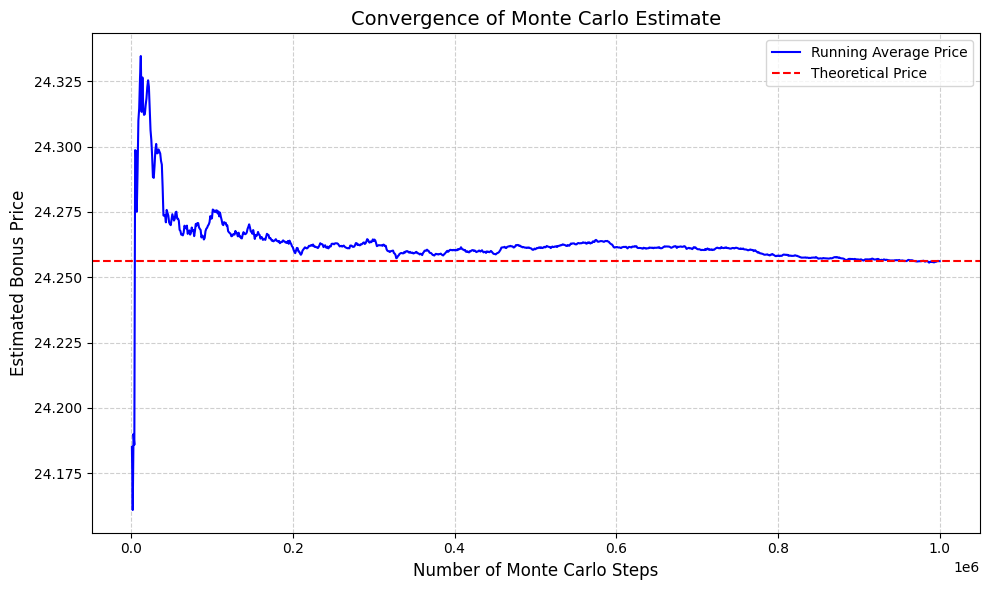

In [46]:
theoreticalBonusPrice = results["Bonus Price"]
montecarloBonusPrice = montecarloResults["Bonus Price"]
relative_error = abs(theoreticalBonusPrice - montecarloBonusPrice) / theoreticalBonusPrice * 100  # in %

print(f"Theoretical Bonus Price: ${theoreticalBonusPrice:.3f}")
print(f"Monte Carlo Bonus Price: ${montecarloBonusPrice:.3f}")
print(f"Relative Error: {relative_error:.2f}%")

plt.figure(figsize=(10, 6))
x_vals = np.arange(1000, MC_steps + 1, 1000)
plt.plot(x_vals, runningAverages, label='Running Average Price', color='blue', linewidth=1.5)
plt.axhline(montecarloResults["Bonus Price"], color='red', linestyle='--', label='Theoretical Price')

plt.xlabel("Number of Monte Carlo Steps", fontsize=12)
plt.ylabel("Estimated Bonus Price", fontsize=12)
plt.title("Convergence of Monte Carlo Estimate", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### Task 7: Simulation under the Physical Measure

Simulate the underlying asset and the certificate payoff under the **physical (real-world) probability measure**. 

Compare the distributions of the payoff and the underlying asset by computing their **mean**, **variance**, **skewness**, **kurtosis**, and the **5% quantile** (also known as the **Value-at-Risk**). 

What do you observe from these statistics?

According to the Black-Scholes model, under the real-world measure $\mathbb{Q}$, the price process $P_t$ follows:

$$
P_t = P_0 \, e^{\left(b - \frac{1}{2}\sigma^2\right) t - \sigma W_t}
$$

where:

- $b$ is the drift of the underlying,
- $\sigma$ is its volatility,
- $W_t$ is a Brownian motion under the real-world measure $\mathbb{Q}$.

In [48]:
from tqdm import tqdm

PT = []
payoffs = []
for _ in tqdm(range(1_000_000)):
    _,Pt = PriceProcess(T,P0,sigma,b)
    PT.append(Pt[-1])
    payoff,hit = BonusPayoff(Pt,H,B,Capped=None)
    payoffs.append(payoff)

PT = np.array(PT)
payoffs = np.array(payoffs)

def compute_stats(X: np.array):
    mean = np.mean(X)
    std = np.std(X)
    return {
        'mean': mean,
        'variance': np.var(X),
        'skewness': np.mean(((X - mean) / std)**3),
        'kurtosis': np.mean(((X - mean) / std)**4),
        '5% quantile (VaR)': np.quantile(X, 0.05)
    }

pd.DataFrame([compute_stats(PT),compute_stats(payoffs)],
             index=['Underlying Price at T','Bonus Certificate Payoff']).T






100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [05:19<00:00, 3127.87it/s]


,Underlying Price at T,Bonus Certificate Payoff
mean,24.534667,25.848730
variance,27.771509,19.069738
skewness,0.647635,0.660980
kurtosis,3.745227,5.990618
5% quantile (VaR),16.903469,17.673897


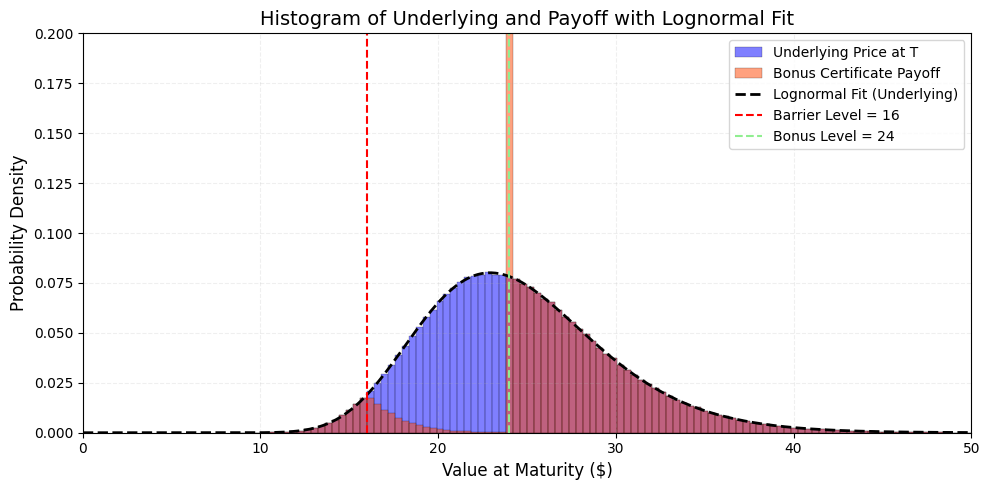

In [49]:
from scipy.stats import lognorm

# Fit a lognormal distribution to the underlying
s = sigma
scale = P0 * np.exp(b - 0.5 * sigma * sigma * T)
x = np.linspace(0.01, 50, 1000)
y = lognorm.pdf(x, s=s, scale=scale)

plt.figure(figsize=(10, 5))

# Plot histograms
plt.hist(PT, bins=150, density=True, alpha=0.5, color='blue',
         edgecolor='black', linewidth=0.3, label='Underlying Price at T')

plt.hist(payoffs, bins=150, density=True, alpha=0.5, color='orangered',
         edgecolor='black', linewidth=0.3, label='Bonus Certificate Payoff')

# Plot fitted lognormal PDF
plt.plot(x, y, color='black', linestyle='--', linewidth=2,
         label='Lognormal Fit (Underlying)')

# Add vertical reference lines
plt.axvline(x=H, color='red', linestyle='--', linewidth=1.5, alpha=1, label=f'Barrier Level = {H}')
plt.axvline(x=B, color='lightgreen', linestyle='--', linewidth=1.5, alpha=1, label=f'Bonus Level = {B}')

# Labels, legend, and layout
plt.title('Histogram of Underlying and Payoff with Lognormal Fit', fontsize=14)
plt.xlabel('Value at Maturity ($)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.xlim(0, 50)
plt.ylim(0, 0.2)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

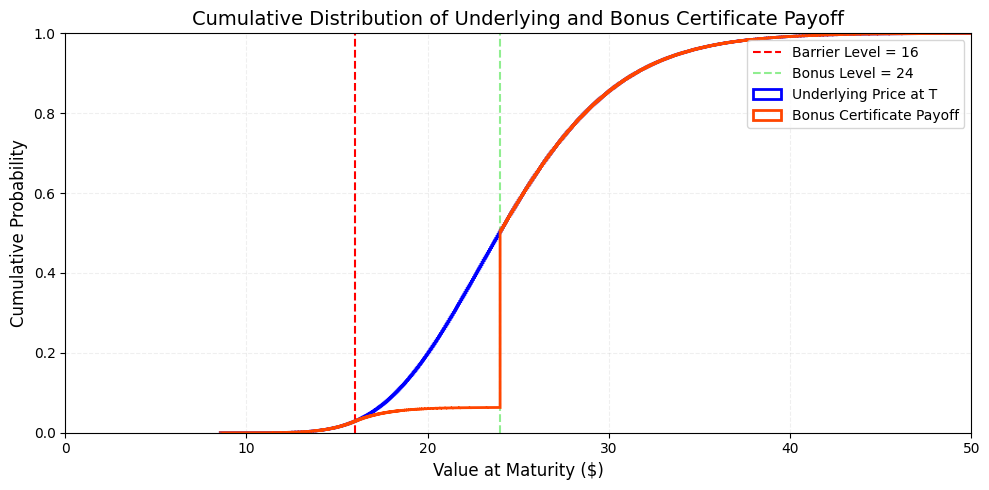

In [50]:
plt.figure(figsize=(10, 5))

# Barrier and bonus level reference lines
plt.axvline(x=H, color='red', linestyle='--', label=f'Barrier Level = {H}')
plt.axvline(x=B, color='lightgreen', linestyle='--', label=f'Bonus Level = {B}')

plt.hist(PT, bins=1000, density=True, cumulative=True,
         histtype='step', color='blue', linewidth=2,
         label='Underlying Price at T')

plt.hist(payoffs, bins=1000, density=True, cumulative=True,
         histtype='step', color='orangered', linewidth=2,
         label='Bonus Certificate Payoff')

plt.title('Cumulative Distribution of Underlying and Bonus Certificate Payoff', fontsize=14)
plt.xlabel('Value at Maturity ($)', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.xlim(0, 50)
plt.ylim(0, 1)

# Legend and grid
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()